In [1]:
!pip install accelerate -U

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00


#Dataset overview


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', 500)

data =  pd.read_csv('all-data.csv', names = ['labels','messages'],lineterminator="\n", sep=';')
data

,labels,messages
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\r"
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .\r"
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .\r"
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .\r
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .\r"
...,...,...
15593,negative,"Negative on Chambal, Advanta: Mitesh Thacker\r"
15594,positive,"Small, Mid-cap stocks may emerge outperformers\r"
15595,neutral,Rupee slips against US dollar\r
15596,neutral,Rupee weak against US dollar\r


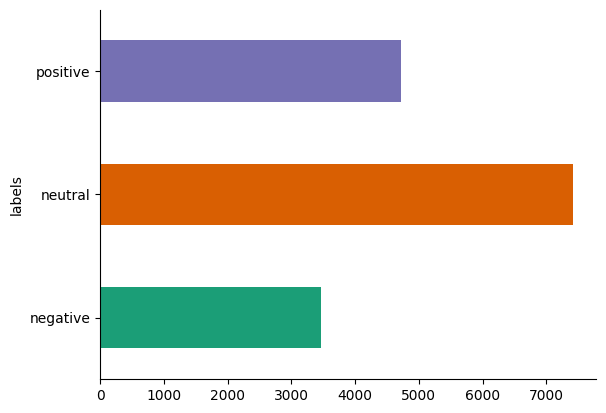

In [4]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-5-3292b9dcde48>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data.labels, palette= 'gray')


<Axes: xlabel='labels', ylabel='count'>

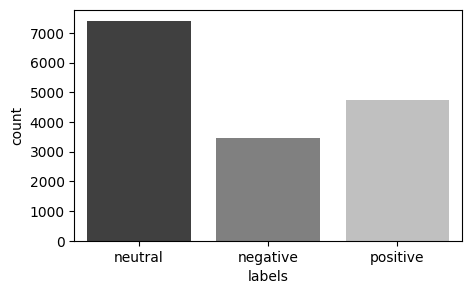

In [5]:
plt.figure(figsize=(5, 3))
sns.countplot(x=data.labels, palette= 'gray')

In [6]:
print(data.shape)
data.labels = data.labels.map( {'positive':0 , 'negative':1, 'neutral':2} )
data.labels.unique()

(15598, 2)


array([2, 1, 0])

In [7]:
data.labels.value_counts()

labels
2    7412
0    4727
1    3459
Name: count, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15598 entries, 0 to 15597
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    15598 non-null  int64 
 1   messages  15598 non-null  object
dtypes: int64(1), object(1)
memory usage: 243.8+ KB


#Getting ready for traing

In [9]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [10]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
data.columns = ['label', 'text']
data = data.dropna(subset=['text', 'label']) ## drop missing values
data.head()

,label,text
0,2,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\r"
1,2,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .\r"
2,1,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .\r"
3,0,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .\r
4,0,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .\r"


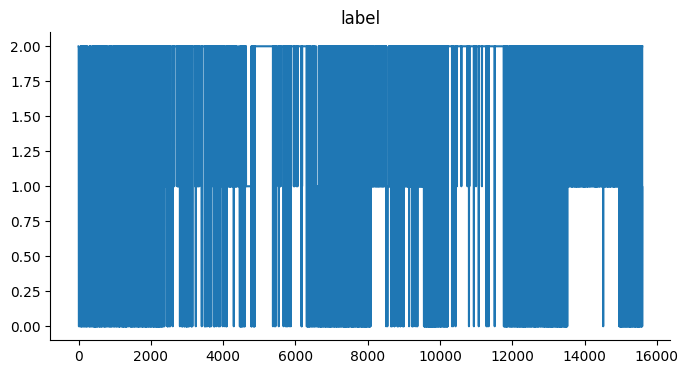

In [12]:
# @title label

from matplotlib import pyplot as plt
data['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [13]:
sentences = data.text.values
labels = data.label.values

In [14]:
!pip install datasets
!pip install sklearn
!pip install torch

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [15]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
# tested in transformers==4.18.0, pytorch==1.7.1
import torch
import transformers
torch.__version__, transformers.__version__

('2.2.1+cu121', '4.38.2')

##Load dataset

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', 500)

df =  data

In [17]:
df.columns = ['label', 'sentence']
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.3, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(9826, 2) (4680, 2) (1092, 2)


In [18]:
df = df.dropna(subset=['sentence', 'label'])

##Finetuning Bert

###Load pretrained model

In [40]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###tokenizing and adding attention masks to dataset

###splitting data into train,valid,test datasets

In [20]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/9826 [00:00<?, ? examples/s]

Map:   0%|          | 0/1092 [00:00<?, ? examples/s]

Map:   0%|          | 0/4680 [00:00<?, ? examples/s]

#Training model using Trainer API

In [41]:
import warnings
from transformers import TrainingArguments,Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

warnings.filterwarnings("ignore")


def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}

args = TrainingArguments(
        logging_steps=100,
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        report_to="none"
)

trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset_train,
        eval_dataset=dataset_val,
        compute_metrics=compute_metrics,

        )



train_result = trainer.train()

trainer.evaluate(metric_key_prefix='test_en',
                eval_dataset=dataset_test)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.490700,0.453091,0.814103,0.812687,0.818370,0.814103
2,0.343900,0.402234,0.846154,0.846251,0.847071,0.846154
3,0.209600,0.458879,0.850733,0.850855,0.852242,0.850733
4,0.150100,0.510165,0.853480,0.853625,0.854750,0.853480
5,0.096400,0.550552,0.851648,0.851733,0.852110,0.851648


Checkpoint destination directory temp/checkpoint-308 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory temp/checkpoint-616 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory temp/checkpoint-924 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory temp/checkpoint-1232 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory temp/checkpoint-1540 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'test_en_loss': 0.5784429907798767,
 'test_en_accuracy': 0.8386752136752137,
 'test_en_f1': 0.838794660639432,
 'test_en_precision': 0.8406218962523924,
 'test_en_recall': 0.8386752136752137,
 'test_en_runtime': 31.6005,
 'test_en_samples_per_second': 148.099,
 'test_en_steps_per_second': 4.652,
 'epoch': 5.0}

#validation set results

In [37]:
model.eval()
trainer.predict(dataset_val).metrics

{'test_loss': 0.6787307262420654,
 'test_accuracy': 0.8507326007326007,
 'test_f1': 0.8507174816634647,
 'test_precision': 0.8507133507133507,
 'test_recall': 0.8507326007326007,
 'test_runtime': 7.9039,
 'test_samples_per_second': 138.159,
 'test_steps_per_second': 5.567}

#test set results

In [38]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.7074652910232544,
 'test_accuracy': 0.8412393162393162,
 'test_f1': 0.8412882270874843,
 'test_precision': 0.84139469984407,
 'test_recall': 0.8412393162393162,
 'test_runtime': 32.9871,
 'test_samples_per_second': 141.874,
 'test_steps_per_second': 5.699}

#Saveing the model

In [24]:
trainer.save_model("fin-senti-bert.h")

In [25]:
text = ["BP Sees Strong Trading Performance in First Quarter", "Tesla to settle over fatal Autopilot crash"
]


texts = [
    "HSBC to sell Argentina business in latest market exit",
    "Amazon announces new eco-friendly packaging initiatives",
    "Tesla's stock price surges after strong quarterly earnings report",
    "BP Sees Strong Trading Performance in First Quarter",
    "Wheat Extends Losses on Concerns Around Ample Grain Supply",
    "Panama Papers money-laundering trial begins",
    "Tesla settles case over fatal Autopilot crash of Apple engineer",
    "Small business optimism hits lowest level since 2012: NFIB",
    "Extreme tariffs on Chinese imports could hurt the U.S. more than China",
    "How an election-packed 2024 is shaping up for world markets",
    "BP Sees Strong Oil, Gas Trading Performance in First Quarter",
]

inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

outputs = model(**inputs.to('cuda'))
predictions = torch.softmax(outputs.logits, dim=1)

predicted_classes = torch.argmax(predictions, dim=1).tolist()

class_labels = ["positive", "negative", "neutral"]

for i, predicted_class in enumerate(predicted_classes):
    print("Text:", texts[i])
    print("Predicted class:", class_labels[predicted_class])
    print()


Text: HSBC to sell Argentina business in latest market exit
Predicted class: neutral

Text: Amazon announces new eco-friendly packaging initiatives
Predicted class: neutral

Text: Tesla's stock price surges after strong quarterly earnings report
Predicted class: positive

Text: BP Sees Strong Trading Performance in First Quarter
Predicted class: positive

Text: Wheat Extends Losses on Concerns Around Ample Grain Supply
Predicted class: negative

Text: Panama Papers money-laundering trial begins
Predicted class: neutral

Text: Tesla settles case over fatal Autopilot crash of Apple engineer
Predicted class: neutral

Text: Small business optimism hits lowest level since 2012: NFIB
Predicted class: negative

Text: Extreme tariffs on Chinese imports could hurt the U.S. more than China
Predicted class: negative

Text: How an election-packed 2024 is shaping up for world markets
Predicted class: neutral

Text: BP Sees Strong Oil, Gas Trading Performance in First Quarter
Predicted class: positi

#Checking basline accuracy

In [26]:
from collections import Counter

train_len, test_len = len(df_train), len(df_test)

train_dataset_label_counts = Counter(df_train['label'])
test_dataset_label_counts = Counter(df_test['label'])

print(f"Train dataset: {train_len} samples, {train_dataset_label_counts}")
print(f"Test dataset: {test_len} samples, {test_dataset_label_counts}")

test_majority_class = test_dataset_label_counts.most_common(1)[0]

baseline_accuracy = test_majority_class[1] / test_len

print(f"Baseline accuracy: {baseline_accuracy:.2%}")

Train dataset: 9826 samples, Counter({2: 4669, 0: 2978, 1: 2179})
Test dataset: 4680 samples, Counter({2: 2224, 0: 1418, 1: 1038})
Baseline accuracy: 47.52%


#Evaluating FinBERT

###getting finBERT model

In [28]:
modelFinbert = BertForSequenceClassification.from_pretrained('ProsusAI/finbert',num_labels=3)
tokenizerFinbert = BertTokenizer.from_pretrained('ProsusAI/finbert',num_labels=3)

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [29]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizerFinbert(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizerFinbert(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizerFinbert(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/9826 [00:00<?, ? examples/s]

Map:   0%|          | 0/1092 [00:00<?, ? examples/s]

Map:   0%|          | 0/4680 [00:00<?, ? examples/s]

In [30]:
import warnings
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments("finbert_trainer")


import numpy as np
from datasets import load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

warnings.filterwarnings("ignore")



def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}

trainerFinbert = Trainer(
    model=modelFinbert,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
)

# trainerFinbert.train()
trainerFinbert.evaluate()


{'eval_loss': 0.6416012048721313,
 'eval_accuracy': 0.7701465201465202,
 'eval_f1': 0.7705441791457821,
 'eval_precision': 0.7718659721443419,
 'eval_recall': 0.7701465201465202,
 'eval_runtime': 7.4021,
 'eval_samples_per_second': 147.525,
 'eval_steps_per_second': 18.508}

In [31]:
trainerFinbert.predict(dataset_test).metrics

{'test_loss': 0.6810809969902039,
 'test_accuracy': 0.745940170940171,
 'test_f1': 0.7462790167818925,
 'test_precision': 0.747739849124416,
 'test_recall': 0.745940170940171,
 'test_runtime': 32.7271,
 'test_samples_per_second': 143.001,
 'test_steps_per_second': 17.875}

In [32]:

texts = [
    "HSBC to sell Argentina business in latest market exit",
    "Amazon announces new eco-friendly packaging initiatives",
    "Tesla's stock price surges after strong quarterly earnings report",
    "BP Sees Strong Trading Performance in First Quarter",
    "Wheat Extends Losses on Concerns Around Ample Grain Supply",
    "Panama Papers money-laundering trial begins",
    "Tesla settles case over fatal Autopilot crash of Apple engineer",
    "Small business optimism hits lowest level since 2012: NFIB",
    "Extreme tariffs on Chinese imports could hurt the U.S. more than China",
    "How an election-packed 2024 is shaping up for world markets",
    "BP Sees Strong Oil, Gas Trading Performance in First Quarter",
]

inputs = tokenizerFinbert(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

outputs = modelFinbert(**inputs.to('cuda'))
predictions = torch.softmax(outputs.logits, dim=1)

predicted_classes = torch.argmax(predictions, dim=1).tolist()

class_labels = ["positive", "negative", "neutral"]

for i, predicted_class in enumerate(predicted_classes):
    print("Text:", texts[i])
    print("Predicted class:", class_labels[predicted_class])
    print()

Text: HSBC to sell Argentina business in latest market exit
Predicted class: neutral

Text: Amazon announces new eco-friendly packaging initiatives
Predicted class: positive

Text: Tesla's stock price surges after strong quarterly earnings report
Predicted class: positive

Text: BP Sees Strong Trading Performance in First Quarter
Predicted class: positive

Text: Wheat Extends Losses on Concerns Around Ample Grain Supply
Predicted class: negative

Text: Panama Papers money-laundering trial begins
Predicted class: neutral

Text: Tesla settles case over fatal Autopilot crash of Apple engineer
Predicted class: negative

Text: Small business optimism hits lowest level since 2012: NFIB
Predicted class: negative

Text: Extreme tariffs on Chinese imports could hurt the U.S. more than China
Predicted class: negative

Text: How an election-packed 2024 is shaping up for world markets
Predicted class: neutral

Text: BP Sees Strong Oil, Gas Trading Performance in First Quarter
Predicted class: posi

\